* Importing the needed Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from collections import Counter

from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             f1_score, ConfusionMatrixDisplay,
                             classification_report, r2_score)
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler 


from scipy.stats import pearsonr
from scipy import stats
from cmath import sqrt
import math
import warnings
warnings.filterwarnings("ignore")
import joblib

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Importing the dataset


In [32]:
csv_files = glob.glob('/content/drive/MyDrive/intrusion detection/dataset/*.{}'.format('csv'))
data = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index = True)


In [33]:
data.replace([np.inf, -np.inf], np.nan, inplace = True)
data = data.dropna(axis = "columns", how = "any")

data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849438 entries, 0 to 1849437
Data columns (total 77 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14   Flow IAT Mean                float64
 15   Flow IAT Std                 float64
 16   Flow IAT Max                 int64  
 17   Flow IAT Min                 int64  
 18  Fwd IAT Total         

In [35]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std',
       ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count',

In [36]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DDoS', 'PortScan', 'Bot',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

* Removng unicode characters from the *'Label'* column
* Unify sub-classes under the various types of *attacks*

In [37]:
data[' Label'] = data[' Label'].str.encode('ascii', 'ignore').str.decode('ascii').replace({
    'Web Attack  Brute Force': 'Web Attack', 
    'Web Attack  XSS': 'Web Attack', 
    'Web Attack  Sql Injection': 'Web Attack',
    'FTP-Patator': 'Patator',
    'SSH-Patator': 'Patator',
  })
data[' Label'].value_counts()

BENIGN        1544500
PortScan       158930
DDoS           128027
Patator         13835
Web Attack       2180
Bot              1966
Name:  Label, dtype: int64

* Dropping the 'Label' column
* Scaling feature vector
* Handling categorical data
* Splitting the dataset

In [38]:
y = data[' Label']
X = data.drop([' Label'], axis = 1)

In [39]:
x_labels = X.columns

In [40]:
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=x_labels)
X

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.001343,5.441666e-06,0.000027,0.000014,0.000181,5.461871e-07,0.008864,0.000000,0.010580,0.015065,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001343,7.608333e-06,0.000036,0.000014,0.000247,4.491550e-06,0.012087,0.000000,0.011222,0.018565,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001343,1.015000e-05,0.000027,0.000014,0.001143,4.317624e-06,0.055923,0.000000,0.066753,0.095048,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001343,4.366666e-06,0.000027,0.000014,0.000186,5.644951e-07,0.009106,0.000000,0.010869,0.015476,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001343,6.550000e-06,0.000036,0.000014,0.000252,4.491550e-06,0.012329,0.000000,0.011446,0.018936,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849433,0.849027,5.166666e-07,0.000000,0.000010,0.000002,2.746192e-08,0.000242,0.002581,0.001010,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1849434,0.691798,1.916667e-06,0.000005,0.000003,0.000013,9.153974e-09,0.001249,0.000000,0.002609,0.003076,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1849435,0.000336,1.156300e-02,0.000182,0.000158,0.001123,1.012124e-05,0.018372,0.000000,0.011200,0.015456,...,0.000112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1849436,0.000336,1.833333e-06,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X.shape, y.shape

((1849438, 76), (1849438,))

In [45]:
encoder = preprocessing.LabelEncoder()
y_cat = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.20, random_state = 7)
X_train.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
1353201,0.000809,2.622917e-04,0.000005,0.000007,0.000026,2.685166e-07,0.001289,0.013763,0.005386,0.000000,...,0.000005,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1694334,0.769314,3.083333e-07,0.000000,0.000003,0.000002,9.153974e-09,0.000242,0.002581,0.001010,0.000000,...,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1777875,0.006760,1.322041e-01,0.000046,0.000034,0.000510,1.038823e-05,0.035294,0.000000,0.018944,0.036645,...,0.000047,1.0,0.003232,0.00612,0.006006,0.000459,0.063138,0.04475,0.083333,0.042939
404455,0.006760,1.580583e-04,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
433838,0.000809,4.149750e-04,0.000000,0.000003,0.000022,1.251043e-07,0.002176,0.023226,0.009090,0.000000,...,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


# Forest model

In [ ]:
ForestModel = RandomForestClassifier()
ForestModel.fit(X_train, y_train)

y_pred_forest_test = ForestModel.predict(X_test)
y_pred_forest_test


array([0, 0, 0, ..., 0, 0, 2])

In [ ]:
print('Precision Score', precision_score(y_test, y_pred_forest_test, average = 'micro'))
print('Recall Score', recall_score(y_test, y_pred_forest_test, average = 'micro'))
print('F1 Score', f1_score(y_test, y_pred_forest_test, average = 'micro'))

Precision Score 0.9993538584652651
Recall Score 0.9993538584652651
F1 Score 0.9993538584652651


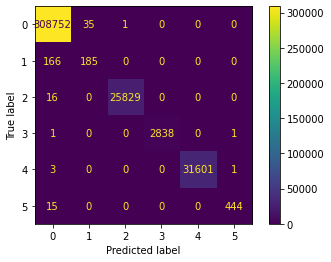

In [ ]:
forest_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_forest_test))
forest_cm.plot()

In [ ]:
# review for possible overfitting:

print(classification_report(y_test, y_pred_forest_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    308788
           1       0.82      0.50      0.62       351
           2       1.00      1.00      1.00     25845
           3       1.00      1.00      1.00      2840
           4       1.00      1.00      1.00     31605
           5       1.00      0.97      0.98       459

    accuracy                           1.00    369888
   macro avg       0.97      0.91      0.93    369888
weighted avg       1.00      1.00      1.00    369888



* Saving Forest model

# Artificial Neural Network (ANN) Model

In [ ]:
#Multi Layer Perceptron classifier

mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.get_params


<bound method BaseEstimator.get_params of MLPClassifier(max_iter=300, random_state=1)>

In [ ]:
mlp.fit(X_train, y_train)
y_pred_mlp_test = mlp.predict(X_test)

print('Precision Score', precision_score(y_test, y_pred_mlp_test, average = 'micro'))
print('Recall Score', recall_score(y_test, y_pred_mlp_test, average = 'micro'))
print('F1 Score', f1_score(y_test, y_pred_mlp_test, average = 'micro'))

Precision Score 0.9972721472445714
Recall Score 0.9972721472445714
F1 Score 0.9972721472445714


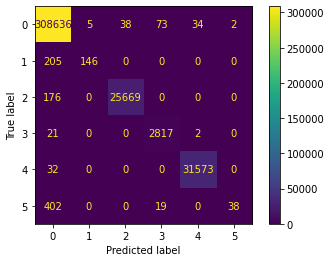

In [ ]:
mlp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp_test))
mlp_cm.plot()

In [ ]:
print(classification_report(y_test, y_pred_mlp_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    308788
           1       0.97      0.42      0.58       351
           2       1.00      0.99      1.00     25845
           3       0.97      0.99      0.98      2840
           4       1.00      1.00      1.00     31605
           5       0.95      0.08      0.15       459

    accuracy                           1.00    369888
   macro avg       0.98      0.75      0.78    369888
weighted avg       1.00      1.00      1.00    369888



# Support Vector Machine

* Skip and run last: runtime suboptimal

In [ ]:
svc = SVC(kernel='rbf', probability=True, gamma="scale", C=1)
svc.fit(X_train, y_train)

y_pred_svc_test = svc.predict(X_test)

print('Precision Score', precision_score(y_test, y_pred_svc_test, average = 'micro'))
print('Recall Score', recall_score(y_test, y_pred_svc_test, average = 'micro'))
print('F1 Score', f1_score(y_test, y_pred_svc_test, average = 'micro'))

In [ ]:
svc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp_test))
svc_cm.plot()

In [ ]:
print(classification_report(y_test, y_pred_mlp_test))

# Undersampling Dataset

In [46]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({'BENIGN': 1544500, 'PortScan': 158930, 'DDoS': 128027, 'Patator': 13835, 'Web Attack': 2180, 'Bot': 1966})


In [47]:
rand_under_sampling = RandomUnderSampler(random_state=42)
X_res, y_res = rand_under_sampling.fit_resample(X, y_cat)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1966, 1: 1966, 2: 1966, 3: 1966, 4: 1966, 5: 1966})


* train-test split for undersampled dataset


In [48]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_res, y_res, test_size = 0.20, random_state = 7)
X_train_rus.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
9772,0.007813,5.416666e-07,0.000000,0.000003,8.235825e-07,9.153974e-09,0.000081,0.00086,0.000337,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8704,0.146410,4.583333e-07,0.000000,0.000003,0.000000e+00,9.153974e-09,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10447,0.001221,4.970653e-02,0.000009,0.000003,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4466,0.001221,5.805675e-03,0.000009,0.000017,1.070657e-05,1.770836e-05,0.000806,0.00000,0.001459,0.001440,...,0.000009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6293,0.000320,1.791667e-06,0.000005,0.000003,5.765077e-06,0.000000e+00,0.000564,0.00000,0.001178,0.001389,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Model (Undersampled)

In [ ]:
ForestModel_rus = RandomForestClassifier()
ForestModel_rus.fit(X_train_rus, y_train_rus)

y_pred_rf_rus = ForestModel_rus.predict(X_test_rus)
y_pred_rf_rus

array([5, 2, 2, ..., 0, 2, 2])

In [ ]:
print('Precision Score', precision_score(y_test_rus, y_pred_rf_rus, average = 'micro'))
print('Recall Score', recall_score(y_test_rus, y_pred_rf_rus, average = 'micro'))
print('F1 Score', f1_score(y_test_rus, y_pred_rf_rus, average = 'micro'))

Precision Score 0.9949152542372881
Recall Score 0.9949152542372881
F1 Score 0.9949152542372881


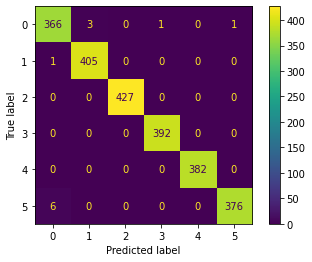

In [ ]:
cm_rus = ConfusionMatrixDisplay(confusion_matrix(y_test_rus, y_pred_rf_rus))
cm_rus.plot()

In [ ]:
print(classification_report(y_test_rus, y_pred_rf_rus))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       371
           1       0.99      1.00      1.00       406
           2       1.00      1.00      1.00       427
           3       1.00      1.00      1.00       392
           4       1.00      1.00      1.00       382
           5       1.00      0.98      0.99       382

    accuracy                           0.99      2360
   macro avg       0.99      0.99      0.99      2360
weighted avg       0.99      0.99      0.99      2360



# Artificial Neural Network Model (Undersampled)

In [ ]:
#Multi Layer Perceptron classifier

mlp_rus = MLPClassifier(random_state=1, max_iter=300)
mlp_rus.get_params


<bound method BaseEstimator.get_params of MLPClassifier(max_iter=300, random_state=1)>

In [ ]:
mlp_rus.fit(X_train_rus, y_train_rus)
y_pred_mlp_rus = mlp_rus.predict(X_test_rus)

print('Precision Score', precision_score(y_test_rus, y_pred_mlp_rus, average = 'micro'))
print('Recall Score', recall_score(y_test_rus, y_pred_mlp_rus, average = 'micro'))
print('F1 Score', f1_score(y_test_rus, y_pred_mlp_rus, average = 'micro'));

Precision Score 0.9800847457627119
Recall Score 0.9800847457627119
F1 Score 0.9800847457627119


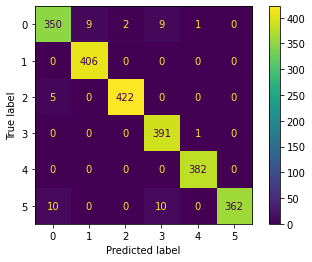

In [ ]:
mlp_cm_rus = ConfusionMatrixDisplay(confusion_matrix(y_test_rus, y_pred_mlp_rus))
mlp_cm_rus.plot()

In [ ]:
print(classification_report(y_test_rus, y_pred_mlp_rus))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       371
           1       0.98      1.00      0.99       406
           2       1.00      0.99      0.99       427
           3       0.95      1.00      0.98       392
           4       0.99      1.00      1.00       382
           5       1.00      0.95      0.97       382

    accuracy                           0.98      2360
   macro avg       0.98      0.98      0.98      2360
weighted avg       0.98      0.98      0.98      2360



# Support Vector Machine (Undersampled)

In [ ]:
svc_rus = SVC(kernel='rbf', probability=True, gamma="scale", C=1)
svc_rus.fit(X_train_rus, y_train_rus)

# predicting based on support vector Machine
y_pred_svc_rus = svc_rus.predict(X_test_rus)

print('Precision Score', precision_score(y_test_rus, y_pred_svc_rus, average = 'micro'))
print('Recall Score', recall_score(y_test_rus, y_pred_svc_rus, average = 'micro'))
print('F1 Score', f1_score(y_test_rus, y_pred_svc_rus, average = 'micro'))

Precision Score 0.8305084745762712
Recall Score 0.8305084745762712
F1 Score 0.8305084745762712


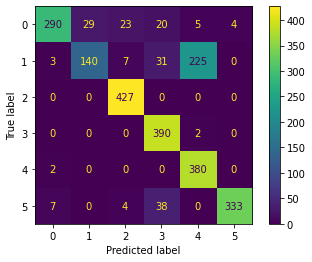

In [ ]:
mlp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test_rus, y_pred_svc_rus))
mlp_cm.plot()

In [ ]:
print(classification_report(y_test_rus, y_pred_svc_rus))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       371
           1       0.83      0.34      0.49       406
           2       0.93      1.00      0.96       427
           3       0.81      0.99      0.90       392
           4       0.62      0.99      0.76       382
           5       0.99      0.87      0.93       382

    accuracy                           0.83      2360
   macro avg       0.86      0.83      0.82      2360
weighted avg       0.86      0.83      0.82      2360

